# Data Visualization And Training Models
## In this notebook the preprocessed data are visualized on charts and ML models are learned. Furthermore model with the best statistic measure (for example accuracy) is picked to save into file.

## 1. Install necessary libraries

In [247]:
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from feature_extraction.feature_extraction import FeatureExtraction
from feature_extraction.utils import PatternCollector
from utils.measure_time import measure_time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from utils.plot_two_cat import PlotTwoCat
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import keras
from keras.src.layers import Dense

## 2. Load preprocessed data from files

In [248]:
path_to_phish_data_file = os.path.join('preprocessed_data', 'phish_data.csv')
path_to_well_known = os.path.join('preprocessed_data', 'well_known.csv')
path_to_non_phish_data_longer = os.path.join('preprocessed_data', 'non_phish_data_longer.csv')
path_to_non_phish_data_shorter = os.path.join('preprocessed_data', 'non_phish_data_shorter.csv')

In [249]:
df1_phish = pd.read_csv(path_to_phish_data_file, index_col='Unnamed: 0', encoding='utf-8')
df1_phish.rename(columns={'PHISH_URL': 'URL'}, inplace=True)

In [250]:
df1_phish.head()

,URL,label
0,https://ollx.1792836.xyz/captcha,1
1,https://ufakick456.com/captcha,1
2,https://keyeseuropean.com/captcha,1
3,https://allegr0lokalnie.83473636.xyz/captcha,1
4,http://ufakick456.com/fb7pl5qw,1


In [251]:
df2_non_phish = pd.read_csv(path_to_non_phish_data_shorter, index_col='Unnamed: 0')
df2_non_phish.rename(columns={'NON_PHISH_URL': 'URL'}, inplace=True)

In [252]:
df2_non_phish.head()

,URL,label
0,https://releases.jquery.com/,0
1,https://code.jquery.com/,0
2,https://app.ether.fi/blocked,0
3,https://efty.com/d/2zfr2/NeonClaims.com/,0
4,https://www.yahoo.com/?&sid=74508,0


In [253]:
df_well_known = pd.read_csv(path_to_well_known, index_col='Unnamed: 0')
df_well_known

,URL,label
443571,https://www.google.com,0
443572,https://www.facebook.com,0
443573,https://www.youtube.com,0
443574,https://www.wp.pl,0
443575,https://www.google.pl,0
...,...,...
443981,https://www.adobe.com/products/xd.html,0
443982,https://www.invisionapp.com,0
443983,https://www.sketch.com,0
443984,https://www.gimp.org,0


### 2.1 Check the data shape:

In [254]:
df1_phish.shape

(154832, 2)

In [255]:
df2_non_phish.shape

(443946, 2)

In [256]:
df_merged = pd.concat([df1_phish, df2_non_phish])
df_merged

,URL,label
0,https://ollx.1792836.xyz/captcha,1
1,https://ufakick456.com/captcha,1
2,https://keyeseuropean.com/captcha,1
3,https://allegr0lokalnie.83473636.xyz/captcha,1
4,http://ufakick456.com/fb7pl5qw,1
...,...,...
443981,https://www.adobe.com/products/xd.html,0
443982,https://www.invisionapp.com,0
443983,https://www.sketch.com,0
443984,https://www.gimp.org,0


### 2.2 Merge data:

In [257]:
df_merged.shape

(598778, 2)

### 2.3 Drop duplicates:

In [258]:
df_merged.nunique()

URL      598637
label         2
dtype: int64

In [259]:
df_merged[df_merged['URL'].duplicated()]

,URL,label
5654,https://solcold.com/,0
5655,http://solcold.com/,0
5656,https://darkhost.pro:443/,0
5740,https://ciet-itac.ca/fr/user/login,0
5751,http://sistema.gavadent.com/admin/site/login,0
...,...,...
443572,https://www.facebook.com,0
443573,https://www.youtube.com,0
443583,https://www.instagram.com,0
443609,https://www.google.com.br,0


In [260]:
df_merged['URL'].duplicated().sum()

141

In [261]:
df_merged.drop_duplicates(subset=['URL'], inplace=True, keep=False)

In [262]:
df_merged.nunique()

URL      598496
label         2
dtype: int64

### 2.4 Check new shape:

In [263]:
df_merged.shape

(598496, 2)

## 3. Take equal number of rows from both DataFrames (equal distribution of labels)

In [264]:
ONE_CLASS_SET_SIZE = 100_000

### 3.1 Sample rows with label equal 1:

In [265]:
label1_filter = df_merged['label'] == 1
df_urls_1 = df_merged[label1_filter].sample(ONE_CLASS_SET_SIZE)

In [266]:
df_urls_1.shape

(100000, 2)

In [267]:
df_urls_1.groupby('label').count()

,URL
label,
1,100000


### 3.2 Sample rows with label equal 0:

In [268]:
WELL_KNOWN_SIZE = 414
df_urls_2 = df_well_known.sample(WELL_KNOWN_SIZE)
df_urls_2

,URL,label
443984,https://www.gimp.org,0
443611,https://www.jbzd.com.pl,0
443735,https://www.fortyfive.equipment,0
443914,https://www.dart.dev,0
443947,https://www.freecodecamp.org,0
...,...,...
443700,https://www.siteten.store,0
443945,https://www.codecademy.com,0
443731,https://www.fortyone.parts,0
443893,https://www.java.com,0


In [269]:
label0_filter = df_merged['label'] == 0
df_urls_2 = pd.concat([df_merged[label0_filter].sample(ONE_CLASS_SET_SIZE - WELL_KNOWN_SIZE), df_urls_2])

In [270]:
df_urls_2.tail()

,URL,label
443700,https://www.siteten.store,0
443945,https://www.codecademy.com,0
443731,https://www.fortyone.parts,0
443893,https://www.java.com,0
443887,https://www.hundredninetyseven.flowers,0


In [271]:
df_urls_2.shape

(100000, 2)

In [272]:
df_urls_2.groupby('label').count()

,URL
label,
0,100000


### 3.3 Merge DataFrames into one frame:

In [273]:
df_urls = pd.concat([df_urls_1, df_urls_2])

In [274]:
df_urls.shape

(200000, 2)

In [275]:
df_urls.groupby('label').count()

,URL
label,
0,100000
1,100000


In [276]:
df_urls.head()

,URL,label
136732,waitaki.otago.ac.nz/~michael/wp/,1
45762,https://cf-ipfs.com/ipfs/QmfY1eJLnSzxw1cYA93JE...,1
93567,http://deryw.club/444.html,1
79160,http://www.com-turning.com/........f/191253c21...,1
115423,tandecresearch.utk.edu/Developarticle.htm,1


In [277]:
df_urls.tail()

,URL,label
443700,https://www.siteten.store,0
443945,https://www.codecademy.com,0
443731,https://www.fortyone.parts,0
443893,https://www.java.com,0
443887,https://www.hundredninetyseven.flowers,0


### 3.4 Shuffle probes in the set:

In [278]:
df_urls = df_urls.sample(len(df_urls))

In [279]:
df_urls.head(10)

,URL,label
121638,www.sss-mag.com/usb.html,1
376331,https://isitpacked.com/2011/03/31/the-busiest-...,0
142670,www.disconova.com/utu/psfpop3/,1
317270,https://kansascityfrontpage.com/,0
18658,https://tinyurl.com/987724374843,1
74307,http://pastehtml.com/view/bfma6b8tq.html,1
144643,www.df.lth.se/~roubert/dc1000/,1
33204,https://jemi.so/altibox-login,1
227602,https://mylife.com/gerry-yates,0
82989,https://en.wikipedia.org/wiki/Inside_Out_(Cam_...,0


In [280]:
df_urls.tail(10)

,URL,label
437379,https://'9d345009-a-62cb3a1a-s-sites.googlegro...,0
137819,www.dmm.cz/en/dmm_window_dll.htm,1
283181,https://communitywalk.com/christian_education_...,0
44937,https://bve.pages.dev/,1
40370,https://globalmontreal.com/striking+mcgill+sta...,0
214721,https://http://correios.com.br/english/correio...,0
75579,https://youtube.com/watch?v=TU5w10krF2g,0
41352,https://bafkreibla3aoko256bwk3o6r2jsg3bghvjdcu...,1
80443,counniounboundse.online,1
268199,https://192.com/atoz/people/penfold/sophie/,0


In [281]:
df_urls.shape

(200000, 2)

In [282]:
df_urls.groupby('label').count()

,URL
label,
0,100000
1,100000


### 3.5 Check for nulls:

In [283]:
df_urls['URL'].isnull().sum()

0

In [284]:
df_urls['URL'].isnull().sum()

0

### 3.6 Plot distribution of the data:

In [285]:
labels_counts = df_urls['label'].value_counts()
label_desc = labels_counts.index
labels_counts

label
1    100000
0    100000
Name: count, dtype: int64

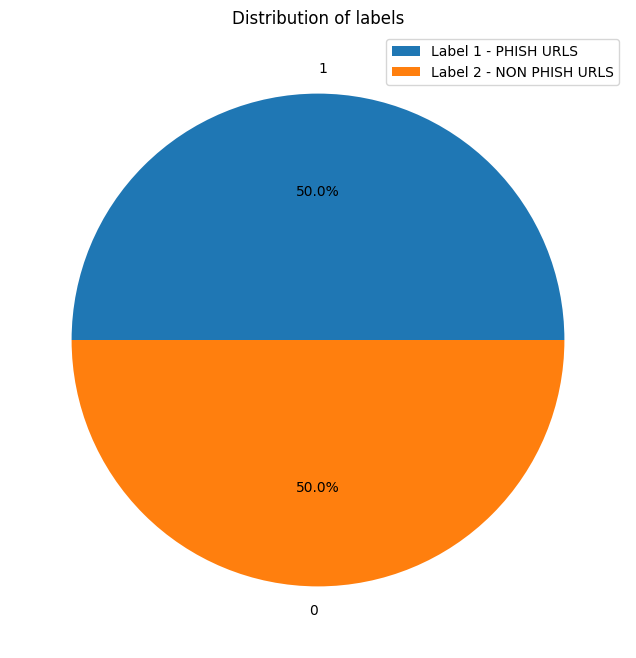

In [286]:
plt.figure(figsize=(8, 8))
plt.pie(labels_counts, labels=label_desc, autopct='%1.1f%%')
plt.title("Distribution of labels")
plt.legend(['Label 1 - PHISH URLS', 'Label 2 - NON PHISH URLS'], loc='upper right')
plt.show()

## 4. Save sampled urls to file

### 4.1 Save to file

In [287]:
df_urls.to_csv(os.path.join('sampled_data', 'sampled_data50to50.csv'), encoding='utf-8')

### 4.2 Save to file

In [288]:
df_urls = pd.read_csv(os.path.join('sampled_data', 'sampled_data50to50.csv'), encoding='utf-8')
df_urls

,Unnamed: 0,URL,label
0,121638,www.sss-mag.com/usb.html,1
1,376331,https://isitpacked.com/2011/03/31/the-busiest-...,0
2,142670,www.disconova.com/utu/psfpop3/,1
3,317270,https://kansascityfrontpage.com/,0
4,18658,https://tinyurl.com/987724374843,1
...,...,...,...
199995,214721,https://http://correios.com.br/english/correio...,0
199996,75579,https://youtube.com/watch?v=TU5w10krF2g,0
199997,41352,https://bafkreibla3aoko256bwk3o6r2jsg3bghvjdcu...,1
199998,80443,counniounboundse.online,1


In [289]:
df_urls.rename(columns={'Unnamed: 0': 'OLD_INDEX'}, inplace=True)
df_urls

,OLD_INDEX,URL,label
0,121638,www.sss-mag.com/usb.html,1
1,376331,https://isitpacked.com/2011/03/31/the-busiest-...,0
2,142670,www.disconova.com/utu/psfpop3/,1
3,317270,https://kansascityfrontpage.com/,0
4,18658,https://tinyurl.com/987724374843,1
...,...,...,...
199995,214721,https://http://correios.com.br/english/correio...,0
199996,75579,https://youtube.com/watch?v=TU5w10krF2g,0
199997,41352,https://bafkreibla3aoko256bwk3o6r2jsg3bghvjdcu...,1
199998,80443,counniounboundse.online,1


## 5. Extract features with previously created methods and add them to DataFrame

### 5.1 Get length of url:

In [290]:
df_urls['URL_LENGTH'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).url_length if FeatureExtraction(url).url_length <= 1000 else 1000)

In [291]:
df_urls.head()

,OLD_INDEX,URL,label,URL_LENGTH
0,121638,www.sss-mag.com/usb.html,1,24
1,376331,https://isitpacked.com/2011/03/31/the-busiest-...,0,83
2,142670,www.disconova.com/utu/psfpop3/,1,30
3,317270,https://kansascityfrontpage.com/,0,31
4,18658,https://tinyurl.com/987724374843,1,32


In [292]:
grouped_by_length = df_urls[['URL_LENGTH', 'URL']].groupby(['URL_LENGTH']).count()
grouped_by_length.tail()

,URL
URL_LENGTH,
940,1
950,1
975,1
996,1
1000,30


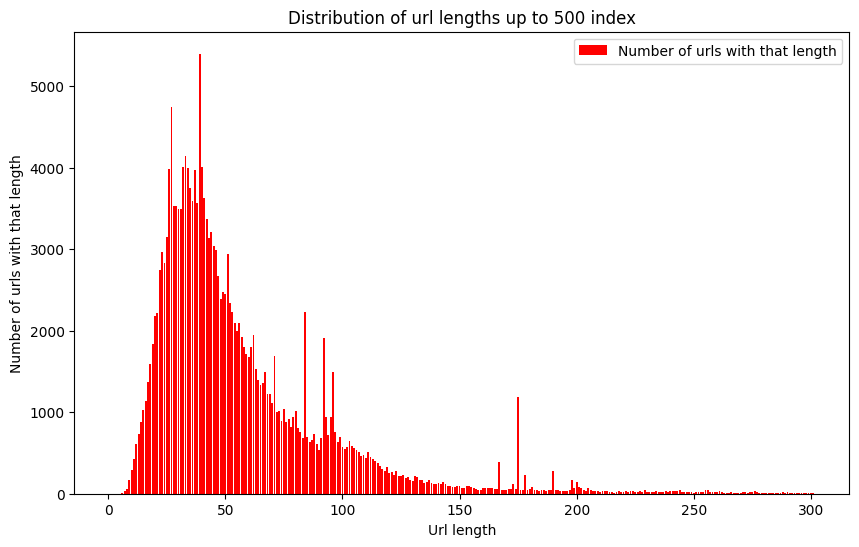

In [293]:
plt.figure(figsize=(10, 6))
plt.bar(grouped_by_length.index[:300], grouped_by_length['URL'][:300], color='red')
plt.title("Distribution of url lengths up to 500 index")
plt.xlabel("Url length")
plt.ylabel("Number of urls with that length")
plt.legend(['Number of urls with that length'], loc='upper right')
plt.show()

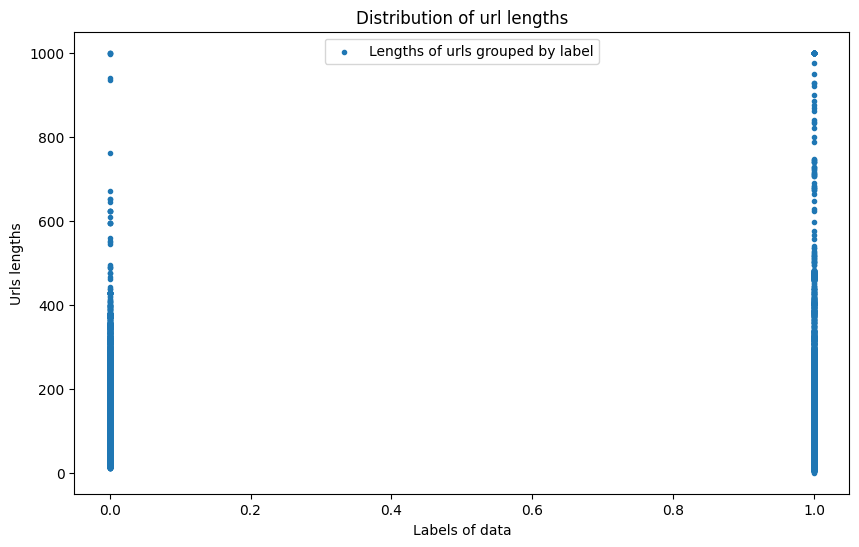

In [294]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['URL_LENGTH'], marker='.')
plt.title("Distribution of url lengths")
plt.xlabel("Labels of data")
plt.ylabel("Urls lengths")
plt.legend(['Lengths of urls grouped by label'], loc='upper center')
plt.show()

### 5.2 Check if URL has @ sign (Commented out because this parameter is redundant  - later the number of @ occurrences is counted):

In [295]:
# df_urls['HAVE_@'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_at_sign() else 0)

In [296]:
# legitimate_and_have_at_filter = (df_urls['HAVE_@'] == 1) & (df_urls['label'] == 0)
# legitimate_and_not_have_at_filter = (df_urls['HAVE_@'] == 0) & (df_urls['label'] == 0)
# phish_and_have_at_filter = (df_urls['HAVE_@'] == 1) & (df_urls['label'] == 1)
# phish_and_not_have_at_filter = (df_urls['HAVE_@'] == 0) & (df_urls['label'] == 1)
# 
# values1 = [len(df_urls[legitimate_and_have_at_filter]), len(df_urls[legitimate_and_not_have_at_filter])]
# values2 = [len(df_urls[phish_and_have_at_filter]), len(df_urls[phish_and_not_have_at_filter])]

In [297]:
# PlotTwoCat(
#     positive_cat='HAVE @',
#     negative_cat='DO NOT HAVE @',
#     title='Bar plot of having @ sign in URL',
#     pos_values=values1,
#     neg_values=values2
# ).plot_by_categories()

### 5.3 Check if URL has IP address instead of domain name:

In [298]:
df_urls['HAVE_IP'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_ip_address() else 0)

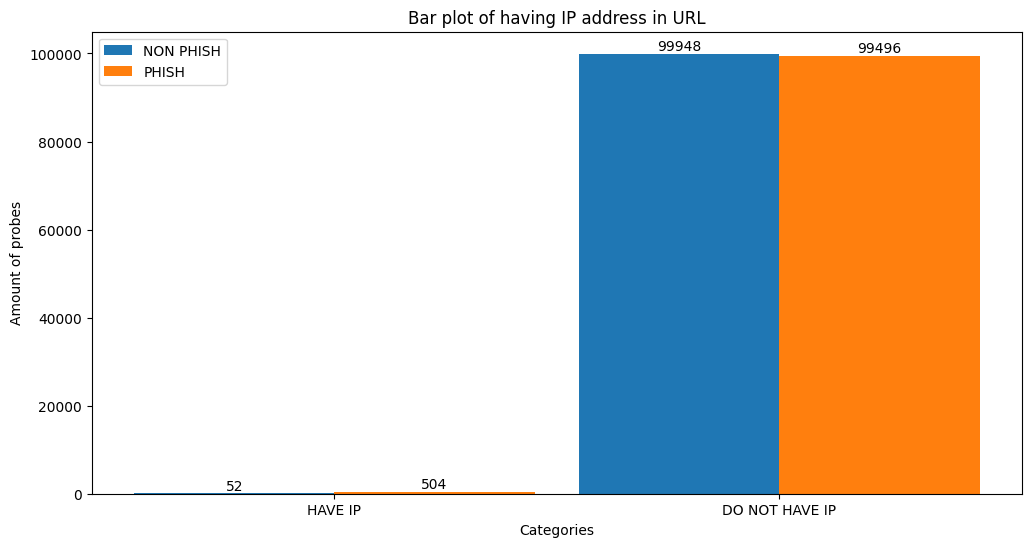

In [299]:
# Filter results
legitimate_and_have_ip_filter = (df_urls['HAVE_IP'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_have_ip_filter = (df_urls['HAVE_IP'] == 0) & (df_urls['label'] == 0)
phish_and_have_ip_filter = (df_urls['HAVE_IP'] == 1) & (df_urls['label'] == 1)
phish_and_not_have_ip_filter = (df_urls['HAVE_IP'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_have_ip_filter]), len(df_urls[legitimate_and_not_have_ip_filter])]
values2 = [len(df_urls[phish_and_have_ip_filter]), len(df_urls[phish_and_not_have_ip_filter])]

PlotTwoCat(
    positive_cat='HAVE IP',
    negative_cat='DO NOT HAVE IP',
    title='Bar plot of having IP address in URL',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()


### 5.4 Check if URL is shorter than mean length in set:

In [300]:
mean_url_length = (df_urls['URL'].apply(lambda url: len(url)).sum()/len(df_urls['URL'])).__floor__()
print(f"Mean URL length: {mean_url_length} chars")

Mean URL length: 59 chars


In [301]:
df_urls['LONGER_THAN_MEAN'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).url_longer_than(mean_url_length) else 0)

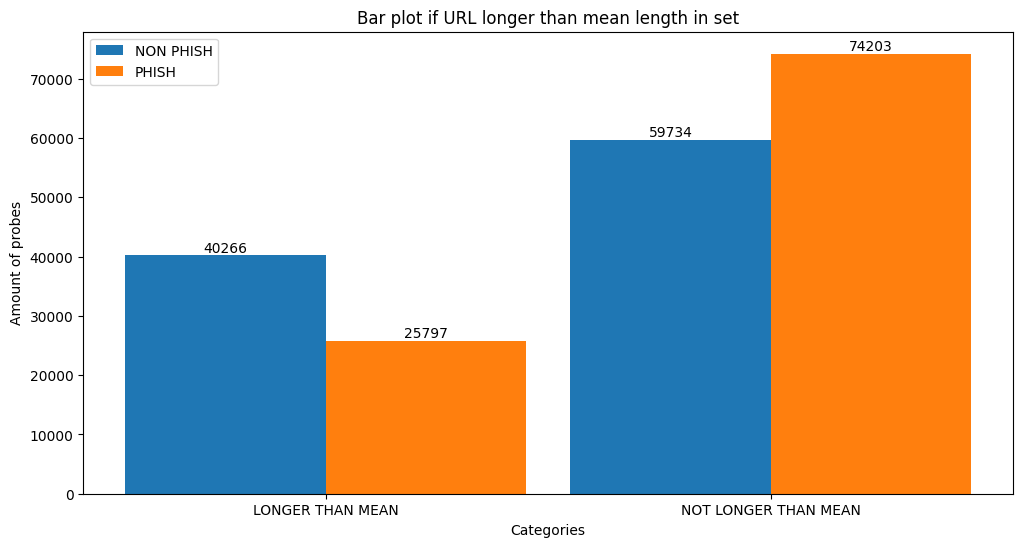

In [302]:
# Filter results
legitimate_and_longer_than_mean_filter = (df_urls['LONGER_THAN_MEAN'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_longer_than_mean_filter = (df_urls['LONGER_THAN_MEAN'] == 0) & (df_urls['label'] == 0)
phish_and_longer_than_mean_filter = (df_urls['LONGER_THAN_MEAN'] == 1) & (df_urls['label'] == 1)
phish_and_not_longer_than_mean_filter = (df_urls['LONGER_THAN_MEAN'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_longer_than_mean_filter]), len(df_urls[legitimate_and_not_longer_than_mean_filter])]
values2 = [len(df_urls[phish_and_longer_than_mean_filter]), len(df_urls[phish_and_not_longer_than_mean_filter])]

PlotTwoCat(
    positive_cat='LONGER THAN MEAN',
    negative_cat='NOT LONGER THAN MEAN',
    title='Bar plot if URL longer than mean length in set',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()


### 5.5 Collect chars from URL:

In [303]:
@measure_time
def collect_chars() -> pd.DataFrame:
    chars_df = pd.DataFrame()
    for c in PatternCollector.chars:
        chars_df[c] = pd.DataFrame.from_dict(df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_characters().get(c)))
    return chars_df

In [304]:
df = collect_chars()

Measured running time of collect_chars: 0:01:46.691834


In [305]:
print(df.shape)
df.head()

(200000, 32)


,!,@,#,$,%,^,&,*,(,),...,<,>,?,/,+,=,-,_,',""""
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,7,0,0,7,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0


In [306]:
df_urls = pd.merge(df_urls, df, left_index=True, right_index=True, how='inner')
print(df_urls.shape)
df_urls.head()

(200000, 38)


,OLD_INDEX,URL,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,...,<,>,?,/,+,=,-,_,',""""
0,121638,www.sss-mag.com/usb.html,1,24,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,376331,https://isitpacked.com/2011/03/31/the-busiest-...,0,83,0,1,0,0,0,0,...,0,0,0,7,0,0,7,0,0,0
2,142670,www.disconova.com/utu/psfpop3/,1,30,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
3,317270,https://kansascityfrontpage.com/,0,31,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
4,18658,https://tinyurl.com/987724374843,1,32,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0


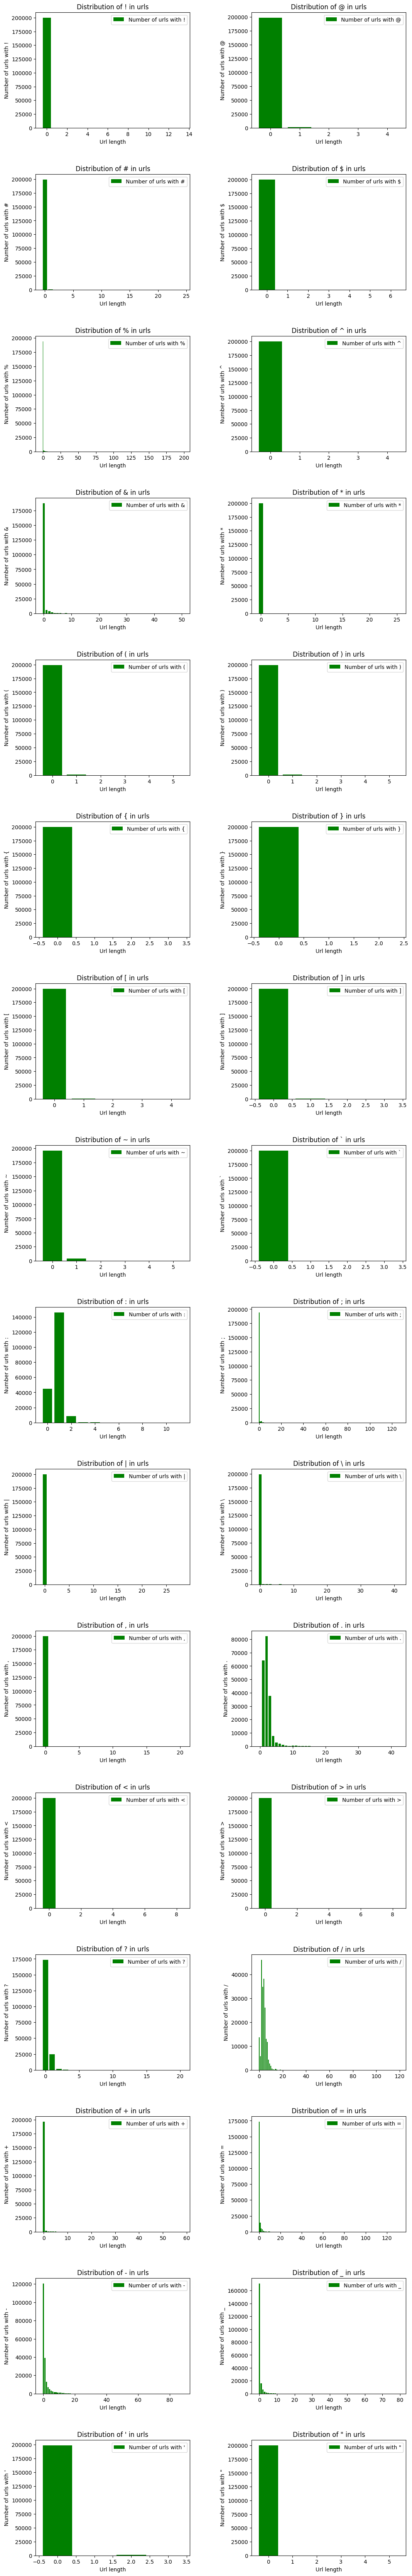

In [307]:
plt.figure(figsize=(12, 60))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.2, 
                    wspace=0.4, 
                    hspace=0.4)
for pos, char in enumerate(PatternCollector.chars):    
    grouped_by_char = df_urls[[char, 'URL']].groupby([char]).count()
    plt.subplot(16, 2, pos+1)
    plt.bar(grouped_by_char.index, grouped_by_char['URL'], color='green', )
    plt.title(f"Distribution of {char} in urls")
    plt.xlabel("Url length")
    plt.ylabel(f"Number of urls with {char}")
    plt.legend([f'Number of urls with {char}'], loc='upper right')

plt.show()

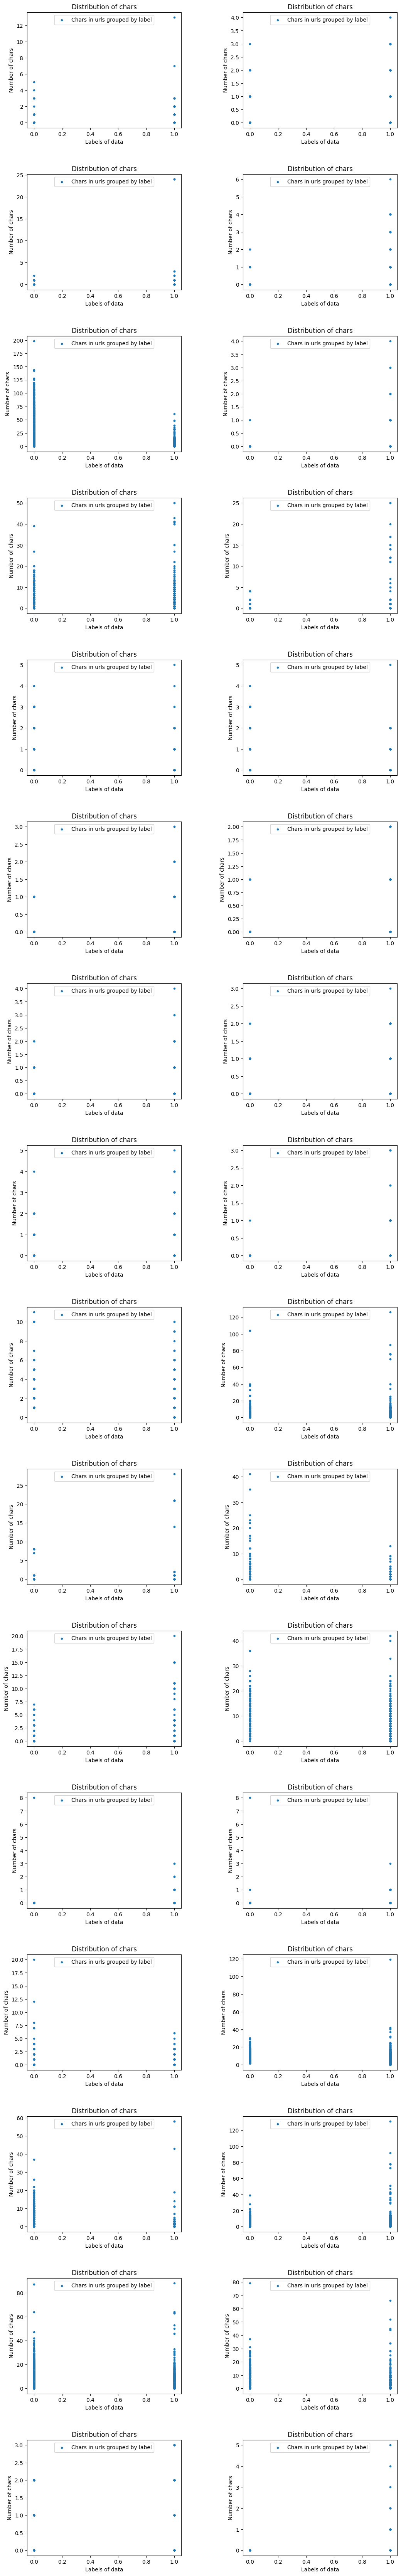

In [308]:
plt.figure(figsize=(12, 60))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.2, 
                    wspace=0.4, 
                    hspace=0.4)
for pos, char in enumerate(PatternCollector.chars):    
    grouped_by_char = df_urls[[char, 'URL']].groupby([char]).count()
    plt.subplot(16, 2, pos+1)
    plt.scatter(df_urls['label'], df_urls[char], marker='.')
    plt.title("Distribution of chars")
    plt.xlabel("Labels of data")
    plt.ylabel("Number of chars")
    plt.legend(['Chars in urls grouped by label'], loc='upper center')

plt.show()

In [309]:
# Count chars and drop that columns in which there are zero chars in any url
for ch in PatternCollector.chars:
    print(f"Number of urls with an once '{ch}': {df_urls[df_urls[ch] != 0][ch].count()}")
    zero_chars_in_set = df_urls[df_urls[ch] != 0][ch].count() == 0
    if zero_chars_in_set:
        df_urls = df_urls.drop(ch, axis=1)


Number of urls with an once '!': 129
Number of urls with an once '@': 1168
Number of urls with an once '#': 791
Number of urls with an once '$': 50
Number of urls with an once '%': 5890
Number of urls with an once '^': 23
Number of urls with an once '&': 12539
Number of urls with an once '*': 77
Number of urls with an once '(': 919
Number of urls with an once ')': 922
Number of urls with an once '{': 106
Number of urls with an once '}': 105
Number of urls with an once '[': 353
Number of urls with an once ']': 356
Number of urls with an once '~': 3869
Number of urls with an once '`': 24
Number of urls with an once ':': 155427
Number of urls with an once ';': 5822
Number of urls with an once '|': 46
Number of urls with an once '\': 888
Number of urls with an once ',': 278
Number of urls with an once '.': 199958
Number of urls with an once '<': 21
Number of urls with an once '>': 17
Number of urls with an once '?': 26584
Number of urls with an once '/': 186304
Number of urls with an once 

### 5.6 Check if url has https scheme:

In [310]:
df_urls['HAVE_HTTPS'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_https() else 0)

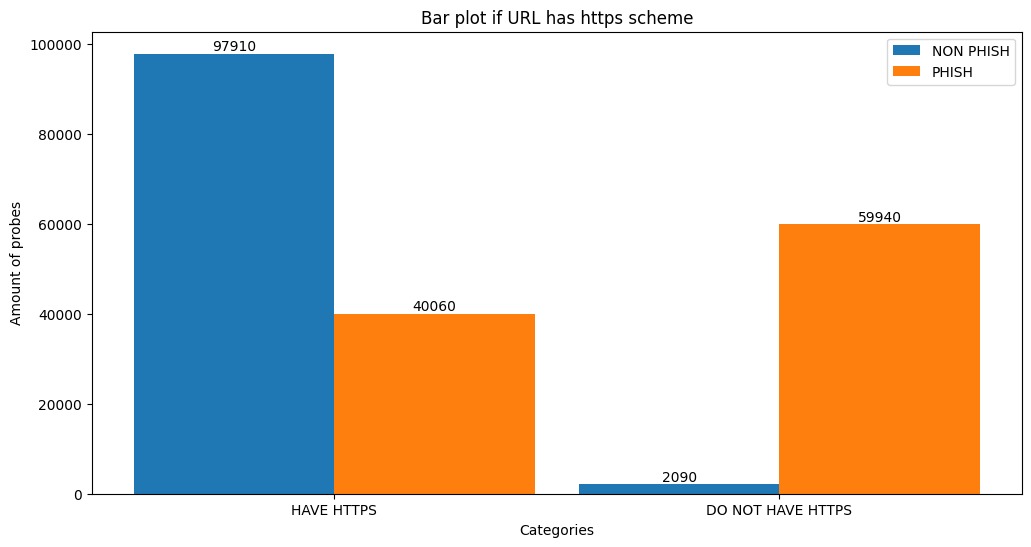

In [311]:
# Filter results
legitimate_and_https_filter = (df_urls['HAVE_HTTPS'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_https_filter = (df_urls['HAVE_HTTPS'] == 0) & (df_urls['label'] == 0)
phish_and_https_filter = (df_urls['HAVE_HTTPS'] == 1) & (df_urls['label'] == 1)
phish_and_not_https_filter = (df_urls['HAVE_HTTPS'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_https_filter]), len(df_urls[legitimate_and_not_https_filter])]
values2 = [len(df_urls[phish_and_https_filter]), len(df_urls[phish_and_not_https_filter])]

PlotTwoCat(
    positive_cat='HAVE HTTPS',
    negative_cat='DO NOT HAVE HTTPS',
    title='Bar plot if URL has https scheme',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()


### 5.7 Check if url is abnormal:

In [312]:
df_urls['ABNORMAL_URL'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).abnormal_url else 0)

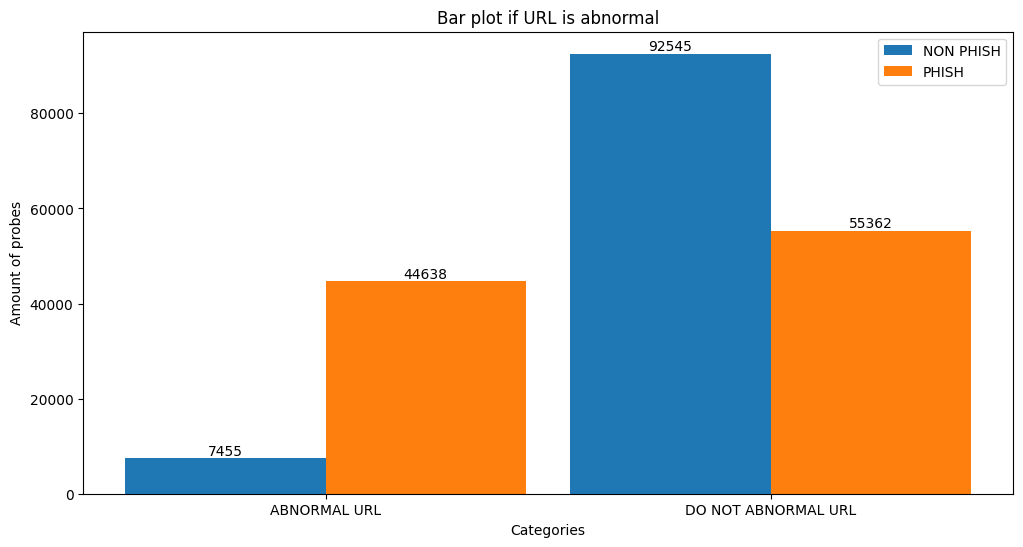

In [313]:
# Filter results
legitimate_and_abnormal_filter = (df_urls['ABNORMAL_URL'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_abnormal_filter = (df_urls['ABNORMAL_URL'] == 0) & (df_urls['label'] == 0)
phish_and_abnormal_filter = (df_urls['ABNORMAL_URL'] == 1) & (df_urls['label'] == 1)
phish_and_not_abnormal_filter = (df_urls['ABNORMAL_URL'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_abnormal_filter]), len(df_urls[legitimate_and_not_abnormal_filter])]
values2 = [len(df_urls[phish_and_abnormal_filter]), len(df_urls[phish_and_not_abnormal_filter])]

PlotTwoCat(
    positive_cat='ABNORMAL URL',
    negative_cat='DO NOT ABNORMAL URL',
    title='Bar plot if URL is abnormal',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()

### 5.8 Count how many digits in the url:

In [314]:
df_urls['DIGITS_AMOUNT'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_digits() if FeatureExtraction(url).count_digits() <= 500 else 500)

In [315]:
counted_digits = df_urls[['URL', 'DIGITS_AMOUNT']].groupby('DIGITS_AMOUNT').count()
counted_digits.tail()

,URL
DIGITS_AMOUNT,
371,1
378,1
404,1
422,1
500,8


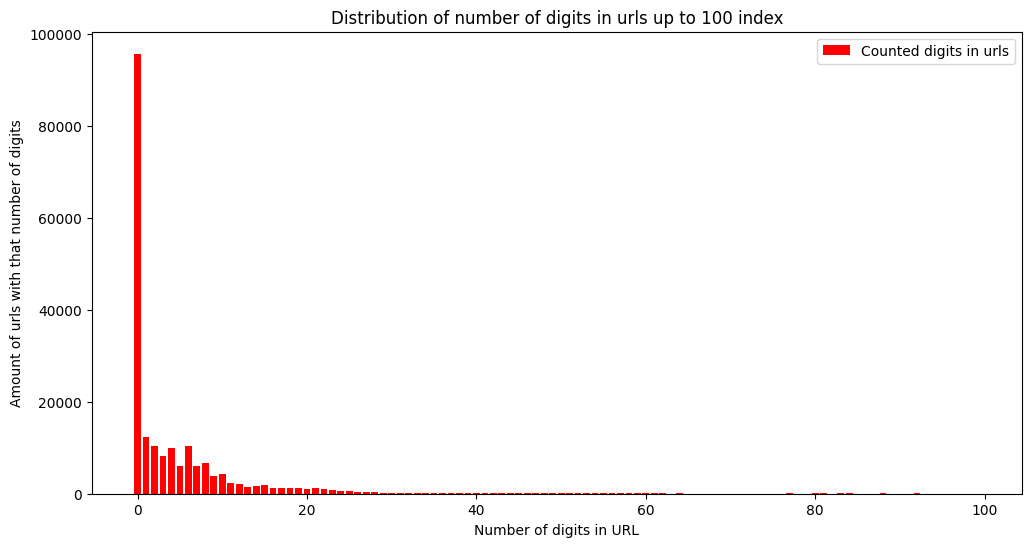

In [316]:
plt.figure(figsize=(12, 6))
plt.bar(counted_digits.index[:100], counted_digits['URL'][:100], color='r')
plt.title('Distribution of number of digits in urls up to 100 index')
plt.xlabel('Number of digits in URL')
plt.ylabel('Amount of urls with that number of digits')
plt.legend(['Counted digits in urls'], loc='best')
plt.show()

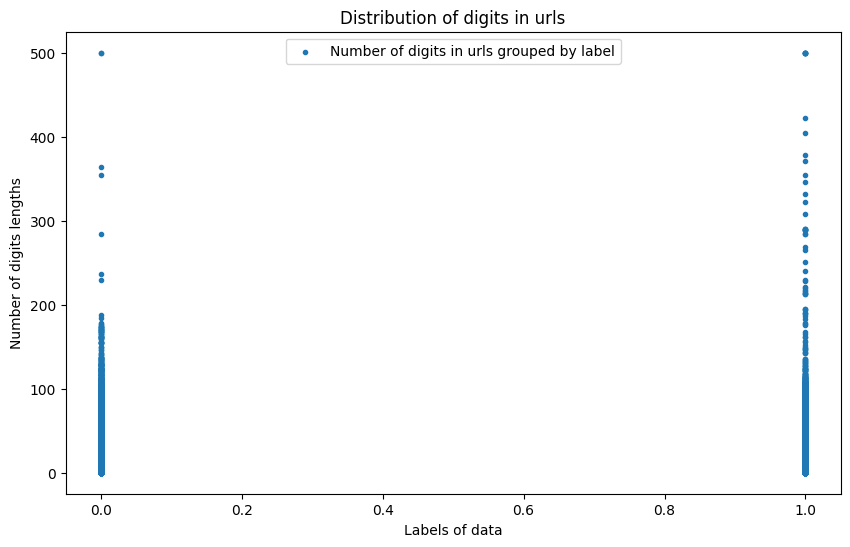

In [317]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['DIGITS_AMOUNT'], marker='.')
plt.title("Distribution of digits in urls")
plt.xlabel("Labels of data")
plt.ylabel("Number of digits lengths")
plt.legend(['Number of digits in urls grouped by label'], loc='upper center')
plt.show()

### 5.9 Count how many letters in url:

In [318]:
df_urls['LETTERS_AMOUNT'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_letters() if FeatureExtraction(url).count_letters() <= 500 else 500)

In [319]:
counted_letters = df_urls[['URL', 'LETTERS_AMOUNT']].groupby('LETTERS_AMOUNT').count()
counted_letters.tail()

,URL
LETTERS_AMOUNT,
487,1
490,1
498,1
499,1
500,58


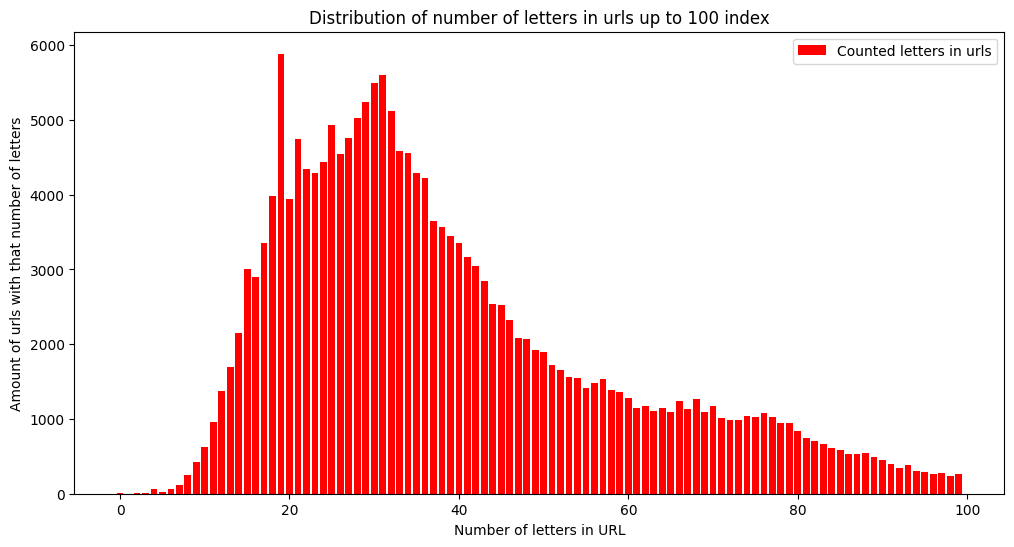

In [320]:
plt.figure(figsize=(12, 6))
plt.bar(counted_letters.index[:100], counted_letters['URL'][:100], color='r')
plt.title('Distribution of number of letters in urls up to 100 index')
plt.xlabel('Number of letters in URL')
plt.ylabel('Amount of urls with that number of letters')
plt.legend(['Counted letters in urls'], loc='best')
plt.show()

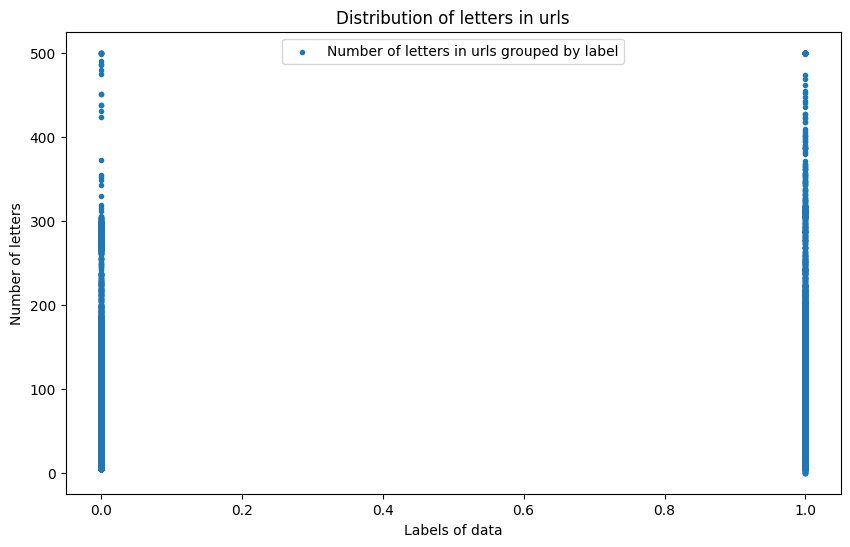

In [321]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['LETTERS_AMOUNT'], marker='.')
plt.title("Distribution of letters in urls")
plt.xlabel("Labels of data")
plt.ylabel("Number of letters")
plt.legend(['Number of letters in urls grouped by label'], loc='upper center')
plt.show()

### 5.10 Path Depth:

In [322]:
df_urls['PATH_DEPTH'] =  df_urls['URL'].apply(lambda url: FeatureExtraction(url).path_depth() if FeatureExtraction(url).path_depth() <= 30 else 30)

In [323]:
path_depth = df_urls[['URL', 'PATH_DEPTH']].groupby('PATH_DEPTH').count()
path_depth

,URL
PATH_DEPTH,
0,45727
1,34250
2,51601
3,32516
4,14429
5,12080
6,4501
7,2510
8,1184


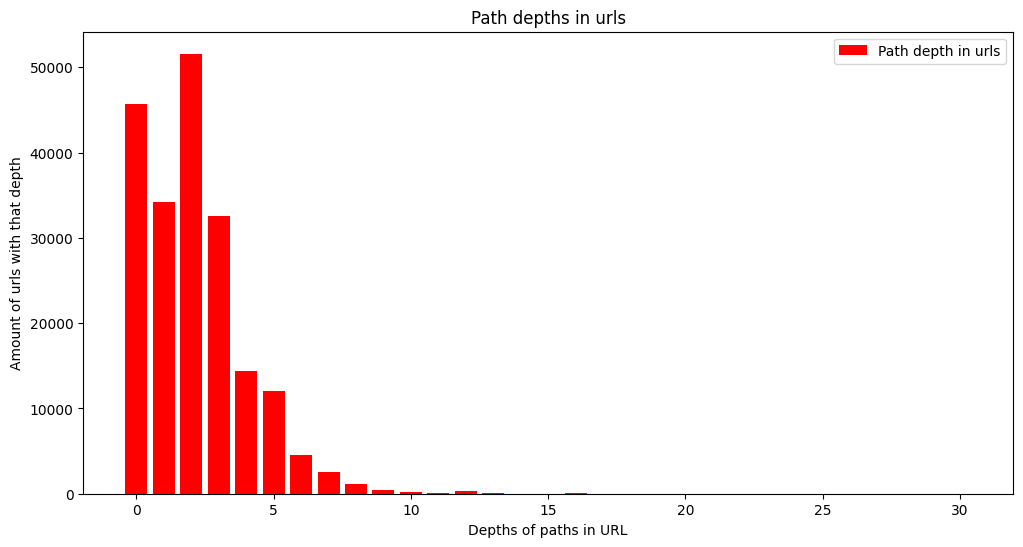

In [324]:
plt.figure(figsize=(12, 6))
plt.bar(path_depth.index, path_depth['URL'], color='r')
plt.title('Path depths in urls')
plt.xlabel('Depths of paths in URL')
plt.ylabel('Amount of urls with that depth')
plt.legend(['Path depth in urls'], loc='best')
plt.show()

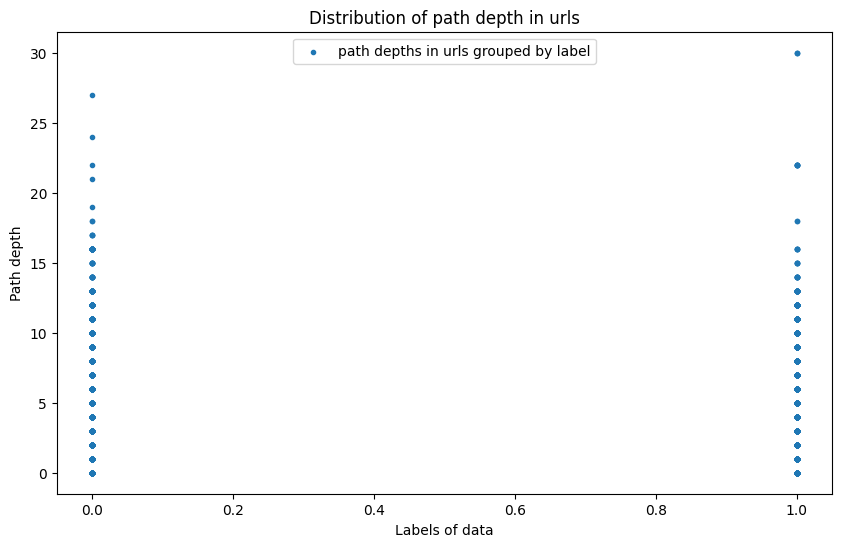

In [325]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['PATH_DEPTH'], marker='.')
plt.title("Distribution of path depth in urls")
plt.xlabel("Labels of data")
plt.ylabel("Path depth")
plt.legend(['path depths in urls grouped by label'], loc='upper center')
plt.show()

### 5.11 Dots in netloc:

In [326]:
df_urls['DOTS_IN_NETLOC'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).dots_in_netloc())

In [327]:
dots_in_netloc = df_urls[['URL', 'DOTS_IN_NETLOC']].groupby('DOTS_IN_NETLOC').count()
dots_in_netloc

,URL
DOTS_IN_NETLOC,
0,7504
1,89430
2,81826
3,16416
4,2141
5,849
6,480
7,207
8,94


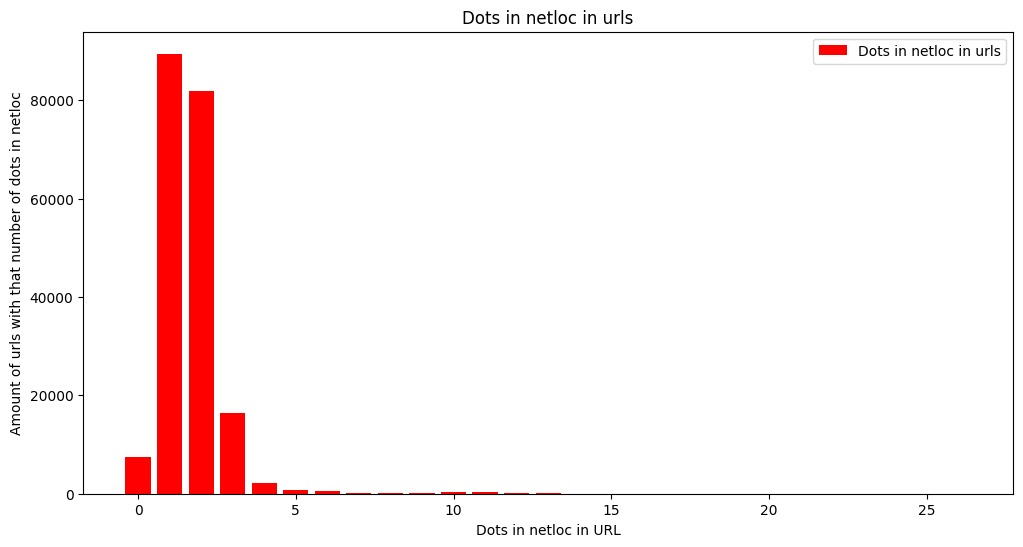

In [328]:
plt.figure(figsize=(12, 6))
plt.bar(dots_in_netloc.index, dots_in_netloc['URL'], color='r')
plt.title('Dots in netloc in urls')
plt.xlabel('Dots in netloc in URL')
plt.ylabel('Amount of urls with that number of dots in netloc')
plt.legend(['Dots in netloc in urls'], loc='best')
plt.show()

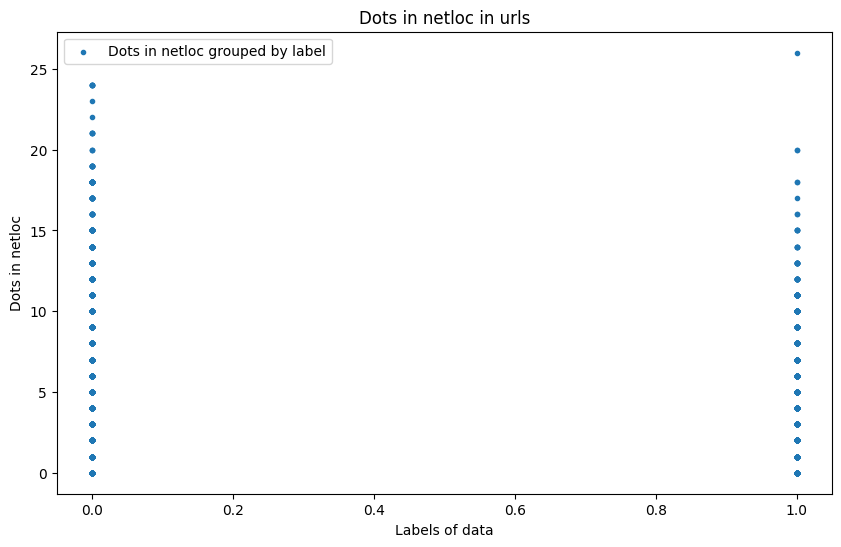

In [329]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['DOTS_IN_NETLOC'], marker='.')
plt.title('Dots in netloc in urls')
plt.xlabel("Labels of data")
plt.ylabel('Dots in netloc')
plt.legend(['Dots in netloc grouped by label'], loc='best')
plt.show()

### 5.12 Netloc length:

In [330]:
df_urls['NETLOC_LEN'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).netloc_length())

In [331]:
netloc_len = df_urls[['URL', 'NETLOC_LEN']].groupby('NETLOC_LEN').count()
netloc_len

,URL
NETLOC_LEN,
0,13
1,1
2,1
4,355
5,7922
...,...
230,2
236,3
237,1


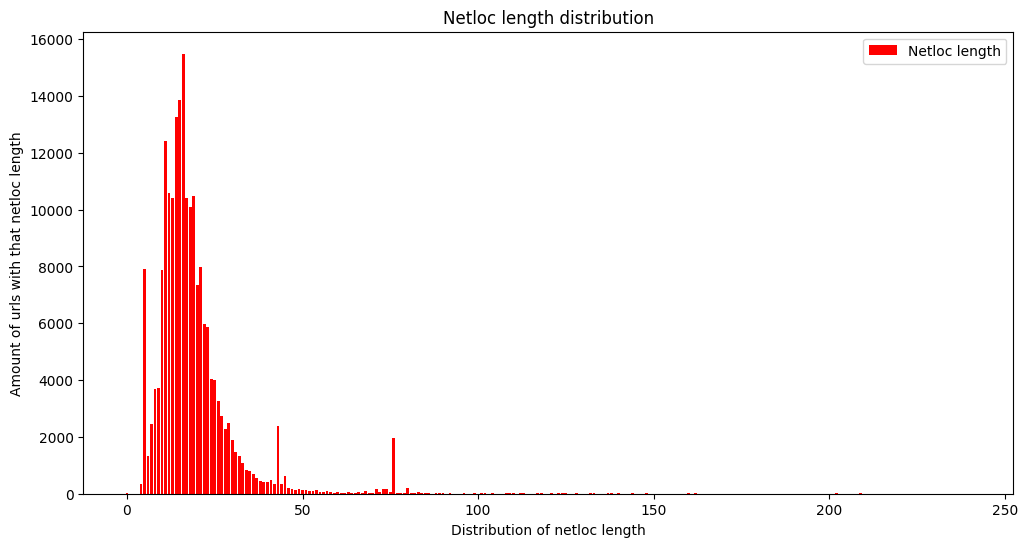

In [332]:
plt.figure(figsize=(12, 6))
plt.bar(netloc_len.index, netloc_len['URL'], color='r')
plt.title('Netloc length distribution')
plt.xlabel('Distribution of netloc length')
plt.ylabel('Amount of urls with that netloc length')
plt.legend(['Netloc length'], loc='best')
plt.show()

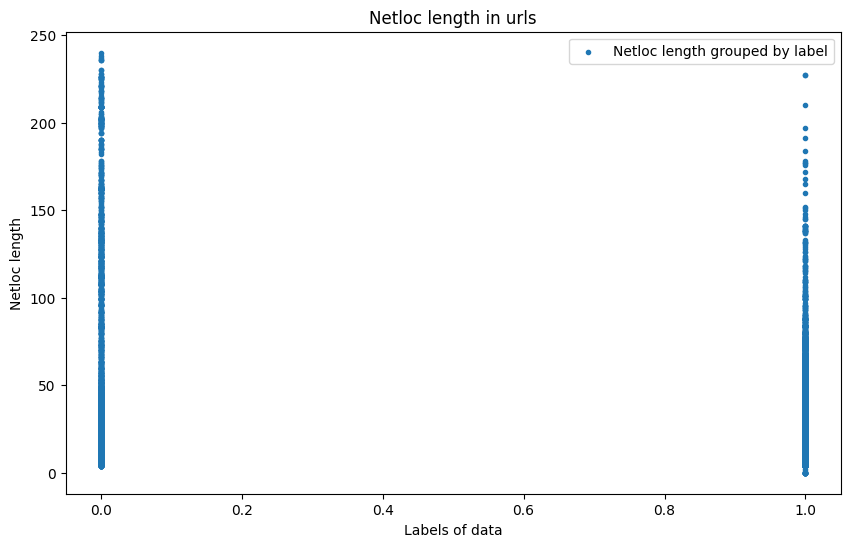

In [333]:
plt.figure(figsize=(10, 6))
plt.scatter(df_urls['label'], df_urls['NETLOC_LEN'], marker='.')
plt.title('Netloc length in urls')
plt.xlabel("Labels of data")
plt.ylabel('Netloc length')
plt.legend(['Netloc length grouped by label'], loc='best')
plt.show()

### 5.13 Check if URL has shortening services pattern:

In [334]:
df_urls['HAVE_SHORTENING_PATTERNS'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_shortening_patterns() else 0)

In [335]:
df_urls[['URL', 'HAVE_SHORTENING_PATTERNS']].tail(20)

,URL,HAVE_SHORTENING_PATTERNS
199980,https://goood.life/wp-admin/,0
199981,https://holdthefloor614.blogspot.com/2009/09/l...,0
199982,www.princeton.edu/~cml/assets/pdf/9608treadwel...,0
199983,https://en.wikipedia.org/wiki/Cap-Saint-Jacque...,0
199984,https://discogs.com/artist/Alexandre+Bilodeau,0
199985,https://bookrags.com/Walter_Winchell,0
199986,https://tatv.tv.hostlogr.com/,0
199987,https://sharetv.org/shows/bosom_buddies,0
199988,ronjaapplegallery.net16.net,0
199989,https://added-recipient-security.firebaseapp.com/,0


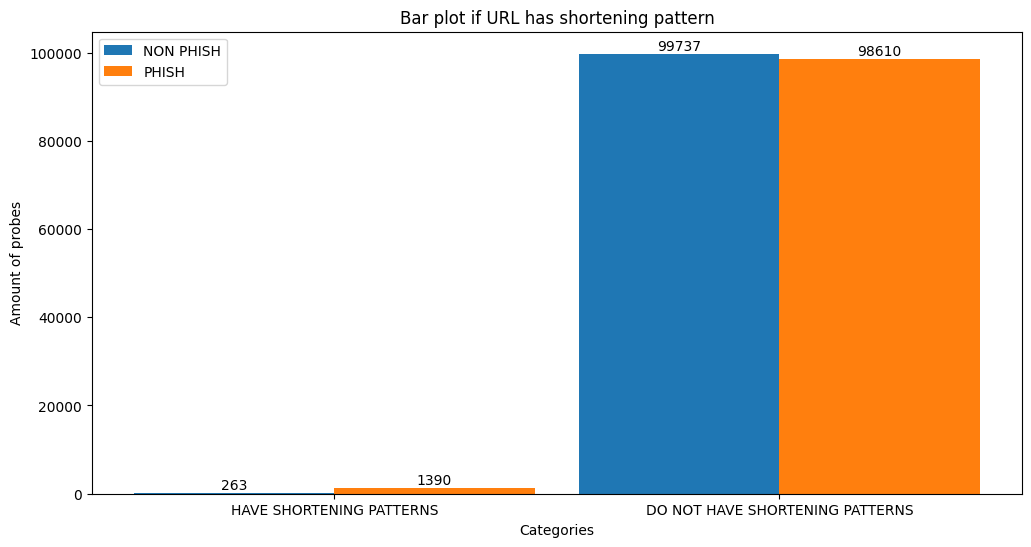

In [336]:
# Filter results
legitimate_and_shortening_pattern_filter = (df_urls['HAVE_SHORTENING_PATTERNS'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_shortening_pattern_filter = (df_urls['HAVE_SHORTENING_PATTERNS'] == 0) & (df_urls['label'] == 0)
phish_and_shortening_pattern_filter = (df_urls['HAVE_SHORTENING_PATTERNS'] == 1) & (df_urls['label'] == 1)
phish_and_not_shortening_pattern_filter = (df_urls['HAVE_SHORTENING_PATTERNS'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_shortening_pattern_filter]), len(df_urls[legitimate_and_not_shortening_pattern_filter])]
values2 = [len(df_urls[phish_and_shortening_pattern_filter]), len(df_urls[phish_and_not_shortening_pattern_filter])]

PlotTwoCat(
    positive_cat='HAVE SHORTENING PATTERNS',
    negative_cat='DO NOT HAVE SHORTENING PATTERNS',
    title='Bar plot if URL has shortening pattern',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()

### 5.14 Check if URL has JavaScript code:

In [337]:
df_urls['HAVE_JS_CODE'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_javascript_code() else 0)

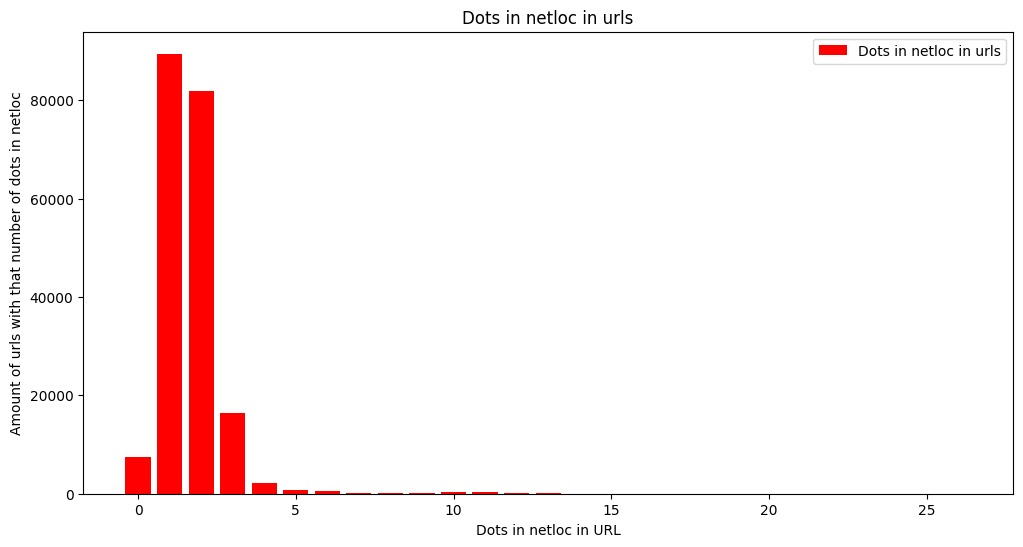

In [338]:
plt.figure(figsize=(12, 6))
plt.bar(dots_in_netloc.index, dots_in_netloc['URL'], color='r')
plt.title('Dots in netloc in urls')
plt.xlabel('Dots in netloc in URL')
plt.ylabel('Amount of urls with that number of dots in netloc')
plt.legend(['Dots in netloc in urls'], loc='best')
plt.show()

In [339]:
df_urls.head()

,OLD_INDEX,URL,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,...,"""",HAVE_HTTPS,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_JS_CODE
0,121638,www.sss-mag.com/usb.html,1,24,0,0,0,0,0,0,...,0,0,1,0,19,1,2,15,0,0
1,376331,https://isitpacked.com/2011/03/31/the-busiest-...,0,83,0,1,0,0,0,0,...,0,1,0,11,56,5,1,14,0,0
2,142670,www.disconova.com/utu/psfpop3/,1,30,0,0,0,0,0,0,...,0,0,1,1,24,3,2,17,0,0
3,317270,https://kansascityfrontpage.com/,0,31,0,0,0,0,0,0,...,0,1,0,0,27,0,1,23,0,0
4,18658,https://tinyurl.com/987724374843,1,32,0,0,0,0,0,0,...,0,1,0,12,15,1,1,11,1,0


### 5.15 Check if URL has www. prefix in netloc:

In [340]:
df_urls['HAVE_WWW_PREFIX'] = df_urls['URL'].apply(lambda url: 1 if FeatureExtraction(url).have_www_in_netloc() else 0)

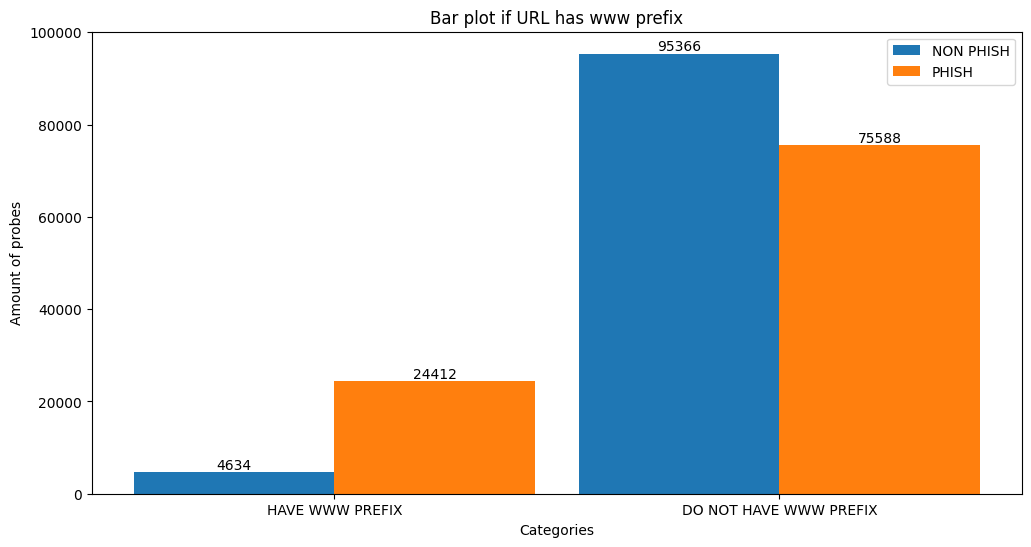

In [341]:
# Filter results
legitimate_and_have_www_filter = (df_urls['HAVE_WWW_PREFIX'] == 1) & (df_urls['label'] == 0)
legitimate_and_not_have_www_filter = (df_urls['HAVE_WWW_PREFIX'] == 0) & (df_urls['label'] == 0)
phish_and_have_www_filter = (df_urls['HAVE_WWW_PREFIX'] == 1) & (df_urls['label'] == 1)
phish_and_not_have_www_filter = (df_urls['HAVE_WWW_PREFIX'] == 0) & (df_urls['label'] == 1)

values1 = [len(df_urls[legitimate_and_have_www_filter]), len(df_urls[legitimate_and_not_have_www_filter])]
values2 = [len(df_urls[phish_and_have_www_filter]), len(df_urls[phish_and_not_have_www_filter])]

PlotTwoCat(
    positive_cat='HAVE WWW PREFIX',
    negative_cat='DO NOT HAVE WWW PREFIX',
    title='Bar plot if URL has www prefix',
    pos_values=values1,
    neg_values=values2
).plot_by_categories()

In [342]:
df_urls

,OLD_INDEX,URL,label,URL_LENGTH,HAVE_IP,LONGER_THAN_MEAN,!,@,#,$,...,HAVE_HTTPS,ABNORMAL_URL,DIGITS_AMOUNT,LETTERS_AMOUNT,PATH_DEPTH,DOTS_IN_NETLOC,NETLOC_LEN,HAVE_SHORTENING_PATTERNS,HAVE_JS_CODE,HAVE_WWW_PREFIX
0,121638,www.sss-mag.com/usb.html,1,24,0,0,0,0,0,0,...,0,1,0,19,1,2,15,0,0,1
1,376331,https://isitpacked.com/2011/03/31/the-busiest-...,0,83,0,1,0,0,0,0,...,1,0,11,56,5,1,14,0,0,0
2,142670,www.disconova.com/utu/psfpop3/,1,30,0,0,0,0,0,0,...,0,1,1,24,3,2,17,0,0,1
3,317270,https://kansascityfrontpage.com/,0,31,0,0,0,0,0,0,...,1,0,0,27,0,1,23,0,0,0
4,18658,https://tinyurl.com/987724374843,1,32,0,0,0,0,0,0,...,1,0,12,15,1,1,11,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,214721,https://http://correios.com.br/english/correio...,0,94,0,1,0,0,0,0,...,1,1,4,71,5,0,5,0,0,0
199996,75579,https://youtube.com/watch?v=TU5w10krF2g,0,39,0,0,0,0,0,0,...,1,0,4,28,1,1,11,0,0,0
199997,41352,https://bafkreibla3aoko256bwk3o6r2jsg3bghvjdcu...,1,84,0,1,0,0,0,0,...,1,0,11,66,0,3,76,0,0,0
199998,80443,counniounboundse.online,1,23,0,0,0,0,0,0,...,0,1,0,22,0,1,23,0,0,0


### 5.16 Count Number of / in path (commented because the redundancy of the parameter):

In [343]:
# df_urls['NUMBER_OF_SLASHES_IN_PATH'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_slashes_in_path())

In [344]:
# number_of_slashes_in_path = df_urls[['URL', 'NUMBER_OF_SLASHES_IN_PATH']].groupby('NUMBER_OF_SLASHES_IN_PATH').count()
# number_of_slashes_in_path

In [345]:
# plt.figure(figsize=(12, 6))
# plt.bar(number_of_slashes_in_path.index, number_of_slashes_in_path['URL'], color='r')
# plt.title('Slashes number distribution')
# plt.xlabel('Distribution of slashes in path')
# plt.ylabel('Amount of urls with that number of slashes')
# plt.legend(['Slashes number'], loc='best')
# plt.show()

### 5.17 Count Number of words in netloc:

In [346]:
df_urls['NUMBER_OF_WORDS_IN_NETLOC'] = df_urls['URL'].apply(lambda url: FeatureExtraction(url).count_words_in_netloc())

In [347]:
number_of_words_in_netloc = df_urls[['URL', 'NUMBER_OF_WORDS_IN_NETLOC']].groupby('NUMBER_OF_WORDS_IN_NETLOC').count()
number_of_words_in_netloc

,URL
NUMBER_OF_WORDS_IN_NETLOC,
1,7504
2,89430
3,81826
4,16416
5,2141
6,849
7,480
8,207
9,94


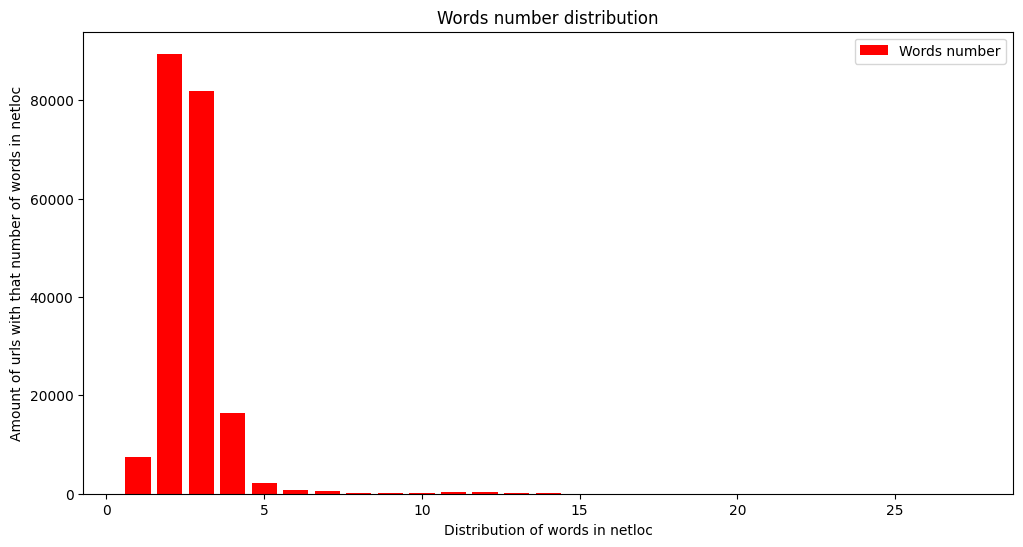

In [348]:
plt.figure(figsize=(12, 6))
plt.bar(number_of_words_in_netloc.index, number_of_words_in_netloc['URL'], color='r')
plt.title('Words number distribution')
plt.xlabel('Distribution of words in netloc')
plt.ylabel('Amount of urls with that number of words in netloc')
plt.legend(['Words number'], loc='best')
plt.show()

W## 6. Learn models

### 6.1 Drop unnecessary or zero columns:

In [349]:
df_urls = df_urls.sample(frac=1)
X = df_urls.drop(['OLD_INDEX', 'URL', 'label'], axis=1)
y = df_urls['label']

In [350]:
print(X.columns.shape)
X.columns

(46,)


Index(['URL_LENGTH', 'HAVE_IP', 'LONGER_THAN_MEAN', '!', '@', '#', '$', '%',
       '^', '&', '*', '(', ')', '{', '}', '[', ']', '~', '`', ':', ';', '|',
       '\', ',', '.', '<', '>', '?', '/', '+', '=', '-', '_', ''', '"',
       'HAVE_HTTPS', 'ABNORMAL_URL', 'DIGITS_AMOUNT', 'LETTERS_AMOUNT',
       'PATH_DEPTH', 'DOTS_IN_NETLOC', 'NETLOC_LEN',
       'HAVE_SHORTENING_PATTERNS', 'HAVE_JS_CODE', 'HAVE_WWW_PREFIX',
       'NUMBER_OF_WORDS_IN_NETLOC'],
      dtype='object')

In [351]:
columns_to_drop = []
for col in X.columns:
    if X[col].sum() == 0:
        columns_to_drop.append(col)
        
X.drop(columns=columns_to_drop, axis=1, inplace=True)

In [352]:
print(X.columns.shape)
X.columns

(45,)


Index(['URL_LENGTH', 'HAVE_IP', 'LONGER_THAN_MEAN', '!', '@', '#', '$', '%',
       '^', '&', '*', '(', ')', '{', '}', '[', ']', '~', '`', ':', ';', '|',
       '\', ',', '.', '<', '>', '?', '/', '+', '=', '-', '_', ''', '"',
       'HAVE_HTTPS', 'ABNORMAL_URL', 'DIGITS_AMOUNT', 'LETTERS_AMOUNT',
       'PATH_DEPTH', 'DOTS_IN_NETLOC', 'NETLOC_LEN',
       'HAVE_SHORTENING_PATTERNS', 'HAVE_WWW_PREFIX',
       'NUMBER_OF_WORDS_IN_NETLOC'],
      dtype='object')

In [353]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 150361 to 24442
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   URL_LENGTH                 200000 non-null  int64
 1   HAVE_IP                    200000 non-null  int64
 2   LONGER_THAN_MEAN           200000 non-null  int64
 3   !                          200000 non-null  int64
 4   @                          200000 non-null  int64
 5   #                          200000 non-null  int64
 6   $                          200000 non-null  int64
 7   %                          200000 non-null  int64
 8   ^                          200000 non-null  int64
 9   &                          200000 non-null  int64
 10  *                          200000 non-null  int64
 11  (                          200000 non-null  int64
 12  )                          200000 non-null  int64
 13  {                          200000 non-null  int64
 14  }    

In [354]:
y.head()

150361    1
164186    0
31641     1
5362      1
53025     1
Name: label, dtype: int64

### 6.2 Split probes into train, validate and test sets

In [355]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test,  = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"X_train shape: {X_train.shape} - Percentage: {X_train.shape[0] / X.shape[0] * 100}%")
print(f"X_val shape: {X_val.shape} - Percentage: {X_val.shape[0] / X.shape[0] * 100}%")
print(f"X_test shape: {X_test.shape} - Percentage: {X_test.shape[0] / X.shape[0] * 100}%")
print(f"y_train shape: {y_train.shape} - Percentage: {y_train.shape[0] / y.shape[0] * 100}%")
print(f"y_val shape: {y_val.shape} - Percentage: {y_val.shape[0] / y.shape[0] * 100}%")
print(f"y_test shape: {y_test.shape} - Percentage: {y_test.shape[0] / y.shape[0] * 100}%")

X_train shape: (120000, 45) - Percentage: 60.0%
X_val shape: (40000, 45) - Percentage: 20.0%
X_test shape: (40000, 45) - Percentage: 20.0%
y_train shape: (120000,) - Percentage: 60.0%
y_val shape: (40000,) - Percentage: 20.0%
y_test shape: (40000,) - Percentage: 20.0%


### 6.3 Configure parameters:

In [356]:
best_accuracy_random_state = 0
best_accuracy_n_estimators = 0
best_accuracy = 0
MIN_RANGE = 0
MAX_RANGE = 200
HOP = 20
best_model = None

### 6.4 Random Forest Classifier:

In [357]:
# RandomForestClassifier
# for n_trees in range(MIN_RANGE + 1, 150, HOP):
#     for state in range(MIN_RANGE + 1, MAX_RANGE, HOP):
#         pipeline = Pipeline([
#         ('scaler', MinMaxScaler()),
#         ('classifier', RandomForestClassifier(random_state=state, n_estimators=state))
#         ])
#         # clf = RandomForestClassifier(random_state=state, n_estimators=131)
#         pipeline.fit(X_train, y_train)
#         y_pred = pipeline.predict(X_val)
#         accuracy = accuracy_score(y_val, y_pred)
#         if best_accuracy < accuracy:
#             best_accuracy_random_state = state
#             best_accuracy_n_estimators = n_trees
#             best_accuracy = accuracy
#             best_model = pipeline
#         print(f"Accuracy of random state {state} and n-trees: {n_trees}: {accuracy}")
#     
# print(f"Best accuracy: {best_accuracy} - random state: {best_accuracy_random_state} - best n estimators: {best_accuracy_n_estimators}")
# best accuracy 0.93215

In [358]:
best_accuracy_n_estimators

0

In [359]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', RandomForestClassifier(random_state=141, n_estimators=141, max_depth=50))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
best_model = pipeline
accuracy

0.93405

In [360]:
y_hat = pipeline.predict(X_test)
accuracy_score(y_test, y_hat)

0.93415

In [361]:
y_hat_test = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_hat_test)

In [362]:
with open(os.path.join('saved_models', 'random_forest_model'), mode='wb') as file_handler:
    pickle.dump(best_model, file_handler)

Best accuracy: 0.92965 - random state: 201

### 6.5 Extra Trees Classifier:

In [363]:
# ExtraTreesClassifier
# best_accuracy_random_state = 0
# best_accuracy = 0
# best_model = None
# for state in range(1, 20, 5):
# 
#     extra_trees_classifier = ExtraTreesClassifier(random_state=state, n_estimators=40)
#     extra_trees_classifier.fit(X_train, y_train)
#     y_pred_extra_trees = extra_trees_classifier.predict(X_val)
#     accuracy = accuracy_score(y_val, y_pred_extra_trees)
#     if best_accuracy < accuracy:
#         best_accuracy_random_state = state
#         best_accuracy = accuracy
#         best_model = extra_trees_classifier
#     print(f"Accuracy of random state {state}: {accuracy}")
#     
# print(f"Best accuracy: {best_accuracy} - random state: {best_accuracy_random_state}")

In [364]:
y_pred_extra_trees= best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_extra_trees)
precision = precision_score(y_test, y_pred_extra_trees)
print("Precision: ", precision)
print("Accuracy: ", accuracy)

Precision:  0.9371142365678438
Accuracy:  0.93415


### 6.6 Logistic Regression:

In [365]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('classifier', LogisticRegression(solver='lbfgs', C=1.0))
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Logistic Regression Accuracy: {accuracy}")

Logistic Regression Accuracy: 0.84045


### 6.6 Save best model:

In [366]:
with open(os.path.join('saved_models', 'random_forest_model_params_best'), mode='wb') as file_handler:
    pickle.dump(best_model, file_handler)

In [367]:
with open(os.path.join('saved_models', 'random_forest_model_params_best'), mode='rb') as file_handler:
    model = pickle.load(file_handler)

In [368]:
# pd.DataFrame(X_test.loc[76434]).transpose()

In [369]:
# y_test.loc[76434]

### 6.7 Multilayer Perceptron:

In [370]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
input_shape = (X_train.shape[1], )

In [371]:
model = keras.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(Dense(100, activation='tanh', name='l1'))
model.add(Dense(100, activation='tanh', name='hidden_layer1'))
model.add(Dense(100, activation='tanh', name='hidden_layer2'))
model.add(Dense(100, activation='tanh', name='hidden_layer3'))
model.add(Dense(100, activation='tanh', name='hidden_layer4'))
model.add(Dense(100, activation='tanh', name='hidden_layer5'))
model.add(Dense(100, activation='tanh', name='hidden_layer6'))
model.add(Dense(100, activation='tanh', name='hidden_layer7'))
model.add(Dense(100, activation='tanh', name='hidden_layer8'))
model.add(Dense(100, activation='tanh', name='hidden_layer9'))
model.add(Dense(1, activation='sigmoid', name='output_layer'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'precision'])
model.fit(X_train_scaled, y_train, epochs=20, batch_size=128)

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8502 - loss: 0.3538 - precision: 0.8818
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8980 - loss: 0.2648 - precision: 0.9099
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9011 - loss: 0.2484 - precision: 0.9145
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9059 - loss: 0.2341 - precision: 0.9189
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9088 - loss: 0.2256 - precision: 0.9206
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9101 - loss: 0.2186 - precision: 0.9217
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9119 - loss: 0.2135 - precision: 0.9237
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9108 - loss: 0.2121 - precision: 0.9204
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9155 - loss: 0.2036 - precision: 0.9259
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 2m

In [372]:
X_test_scaled = scaler.transform(X_test)

loss, accuracy, precision = model.evaluate(X_test_scaled, y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Test loss: {loss * 100:.2f}%')
print(f'Test precision: {precision * 100:.2f}%')

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9219 - loss: 0.1863 - precision: 0.9276
Test accuracy: 92.07%
Test loss: 18.82%
Test precision: 92.80%


In [373]:
with open(os.path.join('saved_models', 'mlp_model'), mode='wb') as file_handler:
    pickle.dump(model, file_handler)